<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

In [58]:
import random
import io
import pickle

import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional, GRU

### Datos
Utilizaremos como dataset canciones de bandas de habla inglés.

In [ ]:
# Descargar la carpeta de dataset
# import os
# import platform
# if os.access('./songs_dataset', os.F_OK) is False:
#     if os.access('songs_dataset.zip', os.F_OK) is False:
#         if platform.system() == 'Windows':
#             !curl https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip -o songs_dataset.zip
#         else:
#             !wget songs_dataset.zip https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
#     !unzip -q songs_dataset.zip   
# else:
#     print("El dataset ya se encuentra descargado")

In [ ]:
# # Posibles bandas
# os.listdir("./songs_dataset/")

In [3]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('lotr.txt', sep='/n', header=None)
df.head()

/var/folders/4l/djq4w_j528l0kn8vz8grry4m0000gn/T/ipykernel_27054/1038148832.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('lotr.txt', sep='/n', header=None)


,0
0,"El Señor de los Anillos es una novela, obra cu..."
1,El Señor de los Anillos narra las aventuras de...
2,J.R.R. Tolkien
3,El Señor de los Anillos
4,Título de la edición original: The Lord of the...


In [4]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 11174


### 1 - Ejemplo de Preprocesamiento
- Hay que transformar las oraciones en tokens.
- Dichas oraciones hay que ajustarlas al tamaño fijo de nuestra sentencia de entrada al modelo.
- Hay que separar las palabras objetivos (target) que el modelo debe predecir en cada sentencia armada.

In [5]:
from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from keras.utils import pad_sequences # se utilizará para padding

# largo de la secuencia, incluye seq input + word output
train_len = 4

In [6]:
# Ejemplo de como transformar una oración a tokens usando keras
text = df.loc[0,0]
text

'El Señor de los Anillos es una novela, obra cumbre del escritor John Ronald Reuel Tolkien, ambientada en un mundo fantástico llamado la Tierra Media hacia el final de su Tercera Edad. El título hace referencia a Sauron, el Señor Oscuro de Mordor, principal villano de la historia, creador del Anillo Único que utilizó para controlar el poder de los demás Anillos. El Señor de los Anillos constituye la continuación de un libro anterior de Tolkien, El Hobbit, que cuenta la historia de cómo el Anillo del Poder pasa a las manos de Bilbo Bolsón, el tío de Frodo Bolsón. En un nivel más profundo, constituye la continuación de otro libro llamado El Silmarillion, que habla de la creación de la Tierra Media y de todas las criaturas que en ella habitan, así como del primer Señor Oscuro, maestro de Sauron, y de las luchas por los Silmarils.'

In [7]:
tokens = text_to_word_sequence(text) # entran oraciones -> salen vectores de N posiciones (tokens)
tokens

['el',
 'señor',
 'de',
 'los',
 'anillos',
 'es',
 'una',
 'novela',
 'obra',
 'cumbre',
 'del',
 'escritor',
 'john',
 'ronald',
 'reuel',
 'tolkien',
 'ambientada',
 'en',
 'un',
 'mundo',
 'fantástico',
 'llamado',
 'la',
 'tierra',
 'media',
 'hacia',
 'el',
 'final',
 'de',
 'su',
 'tercera',
 'edad',
 'el',
 'título',
 'hace',
 'referencia',
 'a',
 'sauron',
 'el',
 'señor',
 'oscuro',
 'de',
 'mordor',
 'principal',
 'villano',
 'de',
 'la',
 'historia',
 'creador',
 'del',
 'anillo',
 'único',
 'que',
 'utilizó',
 'para',
 'controlar',
 'el',
 'poder',
 'de',
 'los',
 'demás',
 'anillos',
 'el',
 'señor',
 'de',
 'los',
 'anillos',
 'constituye',
 'la',
 'continuación',
 'de',
 'un',
 'libro',
 'anterior',
 'de',
 'tolkien',
 'el',
 'hobbit',
 'que',
 'cuenta',
 'la',
 'historia',
 'de',
 'cómo',
 'el',
 'anillo',
 'del',
 'poder',
 'pasa',
 'a',
 'las',
 'manos',
 'de',
 'bilbo',
 'bolsón',
 'el',
 'tío',
 'de',
 'frodo',
 'bolsón',
 'en',
 'un',
 'nivel',
 'más',
 'profundo'

1.1 - Transformar las oraciones en secuencias (tokens) de palabras

In [8]:
# Recorrer todas las filas y transformar las oraciones
# en secuencias de palabras
sentence_tokens = []
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [9]:
# Demos un vistazo
sentence_tokens[:2]

[['el',
  'señor',
  'de',
  'los',
  'anillos',
  'es',
  'una',
  'novela',
  'obra',
  'cumbre',
  'del',
  'escritor',
  'john',
  'ronald',
  'reuel',
  'tolkien',
  'ambientada',
  'en',
  'un',
  'mundo',
  'fantástico',
  'llamado',
  'la',
  'tierra',
  'media',
  'hacia',
  'el',
  'final',
  'de',
  'su',
  'tercera',
  'edad',
  'el',
  'título',
  'hace',
  'referencia',
  'a',
  'sauron',
  'el',
  'señor',
  'oscuro',
  'de',
  'mordor',
  'principal',
  'villano',
  'de',
  'la',
  'historia',
  'creador',
  'del',
  'anillo',
  'único',
  'que',
  'utilizó',
  'para',
  'controlar',
  'el',
  'poder',
  'de',
  'los',
  'demás',
  'anillos',
  'el',
  'señor',
  'de',
  'los',
  'anillos',
  'constituye',
  'la',
  'continuación',
  'de',
  'un',
  'libro',
  'anterior',
  'de',
  'tolkien',
  'el',
  'hobbit',
  'que',
  'cuenta',
  'la',
  'historia',
  'de',
  'cómo',
  'el',
  'anillo',
  'del',
  'poder',
  'pasa',
  'a',
  'las',
  'manos',
  'de',
  'bilbo',
  '

In [11]:
# Código para hacer el desfasaje de las palabras
# según el train_len
text_sequences = []

for i in range(train_len, len(tokens)):
    seq = tokens[i-train_len:i]
    text_sequences.append(seq)

In [ ]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences 

1.2 - Crear los vectores de palabras (word2vec)

Ahora necesitamos pasarlos a números para que lo entienda la red y separar input de output.
- El Input seran integers (word2vec)
- Mientras que el output será one hot encodeado (labels) del tamaño del vocabulario

In [12]:
tok = Tokenizer() 

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado, esta sutileza nos dará un pequeño
# problema al momento de hacer la codificación OHE, pero es sencillo de resolver
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

In [13]:
# Ahora sequences tiene los números "ID", largo 4
sequences

[[2, 6, 1, 7],
 [6, 1, 7, 8],
 [1, 7, 8, 27],
 [7, 8, 27, 28],
 [8, 27, 28, 29],
 [27, 28, 29, 30],
 [28, 29, 30, 31],
 [29, 30, 31, 4],
 [30, 31, 4, 32],
 [31, 4, 32, 33],
 [4, 32, 33, 34],
 [32, 33, 34, 35],
 [33, 34, 35, 12],
 [34, 35, 12, 36],
 [35, 12, 36, 9],
 [12, 36, 9, 10],
 [36, 9, 10, 37],
 [9, 10, 37, 38],
 [10, 37, 38, 13],
 [37, 38, 13, 3],
 [38, 13, 3, 14],
 [13, 3, 14, 15],
 [3, 14, 15, 39],
 [14, 15, 39, 2],
 [15, 39, 2, 40],
 [39, 2, 40, 1],
 [2, 40, 1, 41],
 [40, 1, 41, 42],
 [1, 41, 42, 43],
 [41, 42, 43, 2],
 [42, 43, 2, 44],
 [43, 2, 44, 45],
 [2, 44, 45, 46],
 [44, 45, 46, 16],
 [45, 46, 16, 17],
 [46, 16, 17, 2],
 [16, 17, 2, 6],
 [17, 2, 6, 18],
 [2, 6, 18, 1],
 [6, 18, 1, 47],
 [18, 1, 47, 48],
 [1, 47, 48, 49],
 [47, 48, 49, 1],
 [48, 49, 1, 3],
 [49, 1, 3, 19],
 [1, 3, 19, 50],
 [3, 19, 50, 4],
 [19, 50, 4, 20],
 [50, 4, 20, 51],
 [4, 20, 51, 5],
 [20, 51, 5, 52],
 [51, 5, 52, 53],
 [5, 52, 53, 54],
 [52, 53, 54, 2],
 [53, 54, 2, 21],
 [54, 2, 21, 1],
 [2, 2

In [14]:
# Cantidad de casos (doc) de entrada
print(tok.document_count)

144


In [15]:
# Cantidad de veces que aparece cada palabra
print(len(tok.word_counts))

81


In [16]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'de': 1, 'el': 2, 'la': 3, 'del': 4, 'que': 5, 'señor': 6, 'los': 7, 'anillos': 8, 'en': 9, 'un': 10, 'las': 11, 'tolkien': 12, 'llamado': 13, 'tierra': 14, 'media': 15, 'a': 16, 'sauron': 17, 'oscuro': 18, 'historia': 19, 'anillo': 20, 'poder': 21, 'constituye': 22, 'continuación': 23, 'libro': 24, 'bolsón': 25, 'y': 26, 'es': 27, 'una': 28, 'novela': 29, 'obra': 30, 'cumbre': 31, 'escritor': 32, 'john': 33, 'ronald': 34, 'reuel': 35, 'ambientada': 36, 'mundo': 37, 'fantástico': 38, 'hacia': 39, 'final': 40, 'su': 41, 'tercera': 42, 'edad': 43, 'título': 44, 'hace': 45, 'referencia': 46, 'mordor': 47, 'principal': 48, 'villano': 49, 'creador': 50, 'único': 51, 'utilizó': 52, 'para': 53, 'controlar': 54, 'demás': 55, 'anterior': 56, 'hobbit': 57, 'cuenta': 58, 'cómo': 59, 'pasa': 60, 'manos': 61, 'bilbo': 62, 'tío': 63, 'frodo': 64, 'nivel': 65, 'más': 66, 'profundo': 67, 'otro': 68, 'silmarillion': 69, 'habla': 70, 'creación': 71, 'todas': 72, 'criaturas': 73, 'ella': 74, 'habitan': 

In [17]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'el': 37, 'los': 13, 'señor': 14, 'de': 65, 'anillos': 12, 'es': 4, 'una': 4, 'novela': 4, 'obra': 4, 'cumbre': 4, 'del': 16, 'escritor': 4, 'john': 4, 'ronald': 4, 'reuel': 4, 'tolkien': 8, 'ambientada': 4, 'en': 12, 'un': 12, 'mundo': 4, 'fantástico': 4, 'llamado': 8, 'la': 27, 'tierra': 8, 'media': 8, 'hacia': 4, 'final': 4, 'su': 4, 'tercera': 4, 'edad': 4, 'título': 4, 'hace': 4, 'referencia': 4, 'a': 8, 'sauron': 8, 'oscuro': 8, 'mordor': 4, 'principal': 4, 'villano': 4, 'historia': 8, 'creador': 4, 'anillo': 8, 'único': 4, 'que': 16, 'utilizó': 4, 'para': 4, 'controlar': 4, 'poder': 8, 'demás': 4, 'constituye': 8, 'continuación': 8, 'libro': 8, 'anterior': 4, 'hobbit': 4, 'cuenta': 4, 'cómo': 4, 'pasa': 4, 'las': 12, 'manos': 4, 'bilbo': 4, 'bolsón': 8, 'tío': 4, 'frodo': 4, 'nivel': 4, 'más': 4, 'profundo': 4, 'otro': 4, 'silmarillion': 4, 'habla': 4, 'creación': 4, 'y': 8, 'todas': 4, 'criaturas': 4, 'ella': 4, 'habitan': 4, 'así': 4, 'como': 4, 'pr

### 2 - Preprocesamiento completo
Debemos realizar los mismos pasos que en el ejemplo anterior, pero antes de eso debemos transformar ese dataset de filas de oraciones en un texto completo continuo para poder extraer el vocabulario.

In [86]:
# Vistazo a las primeras filas
df.loc[200:400,0]

200                  Los ojos de Gandalf relampaguearon.
201    —Pronto me llegará el momento de enojarme —dij...
202    Gandalf dio un paso hacia el hobbit y pareció ...
203    Bilbo retrocedió hacia la pared, respirando ag...
204    —No me lo explico, Gandalf —dijo—. Nunca te ha...
                             ...                        
396    Frodo se sentó en silencio, inmóvil: el miedo ...
397    —¡Este anillo! — farfulló —. ¿Cómo rayos vino ...
398    —¡Ah! —dijo Gandalf—. Es una historia muy larg...
399    »Ayer te hablé de Sauron el Grande, el Señor O...
400       —Espero que no suceda en mi época —dijo Frodo.
Name: 0, Length: 201, dtype: object

In [20]:
# Concatenamos todos los rows en un solo valor
corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]
corpus[:1000]

'El Señor de los Anillos es una novela, obra cumbre del escritor John Ronald Reuel Tolkien, ambientada en un mundo fantástico llamado la Tierra Media hacia el final de su Tercera Edad. El título hace referencia a Sauron, el Señor Oscuro de Mordor, principal villano de la historia, creador del Anillo Único que utilizó para controlar el poder de los demás Anillos. El Señor de los Anillos constituye la continuación de un libro anterior de Tolkien, El Hobbit, que cuenta la historia de cómo el Anillo del Poder pasa a las manos de Bilbo Bolsón, el tío de Frodo Bolsón. En un nivel más profundo, constituye la continuación de otro libro llamado El Silmarillion, que habla de la creación de la Tierra Media y de todas las criaturas que en ella habitan, así como del primer Señor Oscuro, maestro de Sauron, y de las luchas por los Silmarils. El Señor de los Anillos narra las aventuras de un grupo de seres: (elfos, hobbits, enanos, humanos), que forman la Comunidad del Anillo en su intento por destrui

In [21]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[:20]

['el',
 'señor',
 'de',
 'los',
 'anillos',
 'es',
 'una',
 'novela',
 'obra',
 'cumbre',
 'del',
 'escritor',
 'john',
 'ronald',
 'reuel',
 'tolkien',
 'ambientada',
 'en',
 'un',
 'mundo']

In [22]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 528420


In [23]:
# Código para hacer el desfasaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
    seq = tokens[i-train_len:i]
    text_sequences.append(seq)

In [95]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[2000:2100]

[['corriente', 'en', 'todas', 'las'],
 ['en', 'todas', 'las', 'tierras'],
 ['todas', 'las', 'tierras', 'de'],
 ['las', 'tierras', 'de', 'los'],
 ['tierras', 'de', 'los', 'reyes'],
 ['de', 'los', 'reyes', 'desde'],
 ['los', 'reyes', 'desde', 'arnor'],
 ['reyes', 'desde', 'arnor', 'hasta'],
 ['desde', 'arnor', 'hasta', 'gondor'],
 ['arnor', 'hasta', 'gondor', 'y'],
 ['hasta', 'gondor', 'y', 'a'],
 ['gondor', 'y', 'a', 'lo'],
 ['y', 'a', 'lo', 'largo'],
 ['a', 'lo', 'largo', 'de'],
 ['lo', 'largo', 'de', 'toda'],
 ['largo', 'de', 'toda', 'la'],
 ['de', 'toda', 'la', 'costa'],
 ['toda', 'la', 'costa', 'del'],
 ['la', 'costa', 'del', 'mar'],
 ['costa', 'del', 'mar', 'desde'],
 ['del', 'mar', 'desde', 'belfalas'],
 ['mar', 'desde', 'belfalas', 'hasta'],
 ['desde', 'belfalas', 'hasta', 'lun'],
 ['belfalas', 'hasta', 'lun', 'sin'],
 ['hasta', 'lun', 'sin', 'embargo'],
 ['lun', 'sin', 'embargo', 'conservaron'],
 ['sin', 'embargo', 'conservaron', 'unos'],
 ['embargo', 'conservaron', 'unos', 'poc

In [25]:
# Proceso de tokenización
tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]

[[5, 49, 1, 8],
 [49, 1, 8, 623],
 [1, 8, 623, 24],
 [8, 623, 24, 14],
 [623, 24, 14, 16061],
 [24, 14, 16061, 1539],
 [14, 16061, 1539, 5809],
 [16061, 1539, 5809, 13],
 [1539, 5809, 13, 11409],
 [5809, 13, 11409, 11410],
 [13, 11409, 11410, 11411],
 [11409, 11410, 11411, 11412],
 [11410, 11411, 11412, 2938],
 [11411, 11412, 2938, 16062],
 [11412, 2938, 16062, 6],
 [2938, 16062, 6, 11],
 [16062, 6, 11, 202],
 [6, 11, 202, 16063],
 [11, 202, 16063, 1287],
 [202, 16063, 1287, 3]]

In [26]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 528416


### 3 - Input y target

In [27]:
# Con numpy es muy fácil realizar el slicing de vectores
ex = np.array([[1,2,3,4],[5,6,7,8]])
ex

array([[1, 2, 3, 4],
       [5, 6, 7, 8]])

In [28]:
# Con numpy es muy fácil realizar el slicing de vectores
print("Dimension:", ex.shape)
print("Todos los elementos:", ex)
print("Todos los elementos menos el último:", ex[:, :-1])

Dimension: (2, 4)
Todos los elementos: [[1 2 3 4]
 [5 6 7 8]]
Todos los elementos menos el último: [[1 2 3]
 [5 6 7]]


In [29]:
input = ex[:,:-1] # todos los rows, menos la ultima col
target = ex[:, -1] # última col de cada row

print("Input:", input)
print("Target:", target)

Input: [[1 2 3]
 [5 6 7]]
Target: [4 8]


In [30]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(528416, 3)
(528416,)


In [37]:
# Palabras del vocabulario
list(tok.index_word.items())[:20]

[(1, 'de'),
 (2, 'y'),
 (3, 'la'),
 (4, 'que'),
 (5, 'el'),
 (6, 'en'),
 (7, 'a'),
 (8, 'los'),
 (9, 'se'),
 (10, 'no'),
 (11, 'un'),
 (12, 'las'),
 (13, 'del'),
 (14, 'una'),
 (15, 'pero'),
 (16, 'lo'),
 (17, 'por'),
 (18, 'con'),
 (19, 'al'),
 (20, 'más')]

In [38]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

30010

In [39]:
y_data_int

array([  8, 623,  24, ..., 217,   1,  52])

In [41]:
# Transformar los datos a oneHotEncoding
# y_data = to_categorical(y_data_int, num_classes=vocab_size)

In [42]:
# En el caso anterior explota porque y_data_int comienza en "1" en vez de "0"
# valor minimo:
min(y_data_int)

1

In [43]:
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size) 
y_data.shape

(528416, 30010)

### 4 - Entrenar el modelo

In [44]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1] 
input_seq_len

3

In [45]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

30010

In [80]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))

model.add(GRU(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(32)) 
model.add(Dense(32, activation='relu'))


# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 3, 5)              150055    
                                                                 
 gru_36 (GRU)                (None, 3, 128)            51840     
                                                                 
 dropout_24 (Dropout)        (None, 3, 128)            0         
                                                                 
 gru_37 (GRU)                (None, 3, 64)             37248     
                                                                 
 dropout_25 (Dropout)        (None, 3, 64)             0         
                                                                 
 gru_38 (GRU)                (None, 3, 128)            74496     
                                                                 
 dropout_26 (Dropout)        (None, 3, 128)          

In [81]:
hist = model.fit(x_data, y_data, epochs=50, validation_split=0.2)

Epoch 1/50
13211/13211 [==============================] - 384s 29ms/step - loss: 7.1747 - accuracy: 0.0465 - val_loss: 7.4805 - val_accuracy: 0.0561
Epoch 2/50
13211/13211 [==============================] - 360s 27ms/step - loss: 6.8790 - accuracy: 0.0476 - val_loss: 7.3291 - val_accuracy: 0.0570
Epoch 3/50
13211/13211 [==============================] - 359s 27ms/step - loss: 6.6395 - accuracy: 0.0646 - val_loss: 7.1964 - val_accuracy: 0.0804
Epoch 4/50
13211/13211 [==============================] - 343s 26ms/step - loss: 6.4761 - accuracy: 0.0725 - val_loss: 7.1601 - val_accuracy: 0.0873
Epoch 5/50
13211/13211 [==============================] - 341s 26ms/step - loss: 6.3589 - accuracy: 0.0782 - val_loss: 7.0934 - val_accuracy: 0.0890
Epoch 6/50
13211/13211 [==============================] - 340s 26ms/step - loss: 6.2721 - accuracy: 0.0815 - val_loss: 7.0699 - val_accuracy: 0.0903
Epoch 7/50
13211/13211 [==============================] - 342s 26ms/step - loss: 6.2127 - accuracy: 0.0835

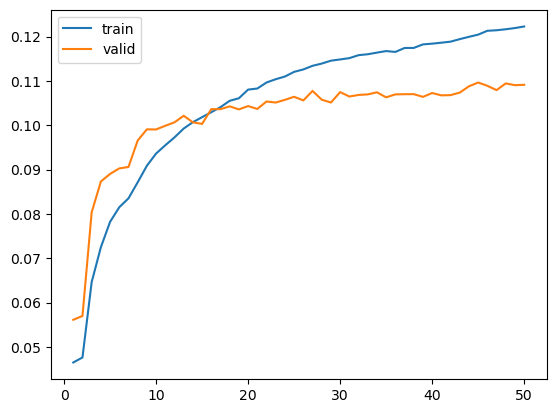

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### 5 - Predicción de próxima palabra

In [ ]:
# Keras pad_sequences
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

In [49]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/
# import sys
# !{sys.executable} -m pip install gradio --quiet

In [83]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')
    
    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

IMPORTANT: You are using gradio version 2.6.4, however version 3.14.0 is available, please upgrade.
--------
Running on local URL:  http://127.0.0.1:7862/

To create a public link, set `share=True` in `launch()`.


1/1 [==============================] - 0s 18ms/step


KeyboardInterrupt: 

### 6 - Generación de secuencias nuevas

In [84]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [85]:
input_text='El señor de los'

generate_seq(model, tok, input_text, max_length=3, n_words=2)

1/1 [==============================] - 0s 16ms/step


'El señor de los qué los'

In [87]:
input_text='Los ojos de'

generate_seq(model, tok, input_text, max_length=3, n_words=2)

1/1 [==============================] - 0s 55ms/step


'Los ojos de y la'

In [88]:
input_text='Ojos de gandalf'

generate_seq(model, tok, input_text, max_length=3, n_words=2)

1/1 [==============================] - 0s 16ms/step


'Ojos de gandalf de y'

In [89]:
input_text='Bilbo retrocedio hacia'

generate_seq(model, tok, input_text, max_length=3, n_words=2)

1/1 [==============================] - 0s 17ms/step


'Bilbo retrocedio hacia que a'

In [93]:
input_text='gandalf el gris'

generate_seq(model, tok, input_text, max_length=3, n_words=2)

1/1 [==============================] - 0s 20ms/step


'gandalf el gris de y'

In [96]:
input_text='nombres personales del'

generate_seq(model, tok, input_text, max_length=3, n_words=2)

1/1 [==============================] - 0s 18ms/step


'nombres personales del yelmo de'

In [97]:
input_text='desde arnor hasta'

generate_seq(model, tok, input_text, max_length=3, n_words=2)

1/1 [==============================] - 0s 17ms/step


'desde arnor hasta la fin'

### 7 - Conclusiones
El modelo entrenado tuvo un muy mail desempeño en el entrenamiento además de overfitting. Cuestiones que podrían mejorarse:
- Agregar más capas o neuronaes
- Incrementar la cantidad de épocas
- Agregar BRNN

Es importante destacar que en este ejemplo estamos entrenando nuestro propios Embeddings, y para ello se requiere mucha data. En los ejemplos que realizaremos de aquí en más utilizaremos más datos, embeddings pre-enternados o modelos pre-entrenados.